In [1]:
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.npya as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    %pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../VIT/EMPR"

# # Setting the seed
# pl.seed_everything(64)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
column = 'label'

mpath = "/media/carol/Data/Documents/Emo_rec/NewMel/Pretraining/Gender"
model_path = os.path.join(mpath, 'model')
processor_path = os.path.join(mpath, 'processor')

model_type = 'DINAT'
# model_path = 'shi-labs/dinat-mini-in1k-224'
# processor_path = 'shi-labs/dinat-mini-in1k-224'


model_path = 'shi-labs/dinat-tiny-in1k-224'
processor_path = 'shi-labs/dinat-tiny-in1k-224'
pathstr = mpath
column = "SpkrID"
new_model_path = os.path.join("/media/carol/Data/Documents/Emo_rec/NewMel/Pretraining", column)



/tmp/ipykernel_24067/3601860349.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
from datasets import load_dataset
dataset_train = 'cairocode/MSPP_SPLIT_MEL2'
train_d0 = load_dataset(dataset_train)

# train_dataset = train_d0['train']
# validation_dataset = train_d0['validation']
# test_dataset = train_d0['test']

Generating test split: 100%|██████████| 21020/21020 [00:02<00:00, 8372.98 examples/s]


In [3]:
# def map_gender(example):
#     example['Gender'] = 0 if example['Gender'] == 'Female' else 1
#     return example

# # Apply the mapping function to the dataset
# train_d0 = train_d0.map(map_gender)

# # Check the updated dataset
# print(train_d0)

In [3]:
import random
from datasets import DatasetDict

# Step 1: Extract unique SpeakerID values
unique_speaker_ids = list(set(train_d0['train']['SpkrID']))

# Step 2: Sample 20% of the unique SpeakerID values
test_speaker_ids = random.sample(unique_speaker_ids, int(0.2 * len(unique_speaker_ids)))

# Step 3: Split the dataset into train and test based on SpeakerID
def split_dataset(example):
    if example['SpkrID'] in test_speaker_ids:
        example['split'] = 'test'
    else:
        example['split'] = 'train'
    return example

# Apply the split
train_d0 = train_d0['train'].map(split_dataset)

# Step 4: Create the train and test datasets
train_set = train_d0.filter(lambda x: x['split'] == 'train').remove_columns('split')
test_dataset = train_d0.filter(lambda x: x['split'] == 'test').remove_columns('split')

# Combine into a DatasetDict if needed
# Check the result

# train_set = train_set.train_test_split(test_size=0.2)

# train_dataset = train_set['train']
# val_dataset = train_set['test']

Filter: 100%|██████████| 116221/116221 [01:42<00:00, 1132.02 examples/s]


In [7]:
from datasets import Dataset, DatasetDict

# Extract 'file' and 'SpkrID' columns from the dataset to create a DataFrame
df = pd.DataFrame({'files': train_set['files'], 'SpkrID': train_set['SpkrID']})

# Shuffle the DataFrame for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Group by SpkrID and assign a split
df['split'] = df.groupby('SpkrID').cumcount() % 5  # Modulo ensures distribution

# Create boolean masks for train and validation sets
train_files = df[df['split'] < 4]['files']  # 80% train
val_files = df[df['split'] >= 4]['files']  # 20% validation

# Map split information back to the original dataset
train_split = train_set.filter(lambda x: x['files'] in set(train_files))
val_split = train_set.filter(lambda x: x['files'] in set(val_files))

# Combine into a DatasetDict
# dataset = DatasetDict({
#     'train': train_split,
#     'validation': val_split
# })

# # Check sizes
print("Training Set Size:", len(dataset['train']))
print("Validation Set Size:", len(dataset['validation']))


Filter: 100%|██████████| 95201/95201 [03:18<00:00, 480.36 examples/s]


NameError: name 'dataset' is not defined

In [8]:
print("Training Set Size:", len(train_split))
print("Validation Set Size:", len(val_split))

Training Set Size: 77058
Validation Set Size: 18143


In [12]:
test_dataset

Dataset({
    features: ['image', 'EmoClass', 'EmoAct', 'EmoVal', 'EmoDom', 'SpkrID', 'Gender', 'Split_Set', 'transcript', 'files'],
    num_rows: 21020
})

In [13]:
from datasets import DatasetDict

ds = DatasetDict({
    'train': train_split,
    'validation': val_split,
    'test': test_dataset
})
ds.push_to_hub("MSPP_SPLIT_MEL2")

Map: 100%|██████████| 11009/11009 [00:02<00:00, 5351.54 examples/s]

Map: 100%|██████████| 11009/11009 [00:02<00:00, 5495.74 examples/s]

Map: 100%|██████████| 11008/11008 [00:02<00:00, 3732.93 examples/s]

Map: 100%|██████████| 11008/11008 [00:02<00:00, 4305.50 examples/s]

Map: 100%|██████████| 11008/11008 [00:02<00:00, 3769.67 examples/s]

Map: 100%|██████████| 11008/11008 [00:02<00:00, 4451.57 examples/s]

Map: 100%|██████████| 11008/11008 [00:03<00:00, 2891.36 examples/s]

Map: 100%|██████████| 9072/9072 [00:15<00:00, 596.60 examples/s] 

Map: 100%|██████████| 9071/9071 [00:05<00:00, 1535.01 examples/s]

Map: 100%|██████████| 10510/10510 [00:02<00:00, 4914.80 examples/s]

Map: 100%|██████████| 10510/10510 [00:02<00:00, 5050.15 examples/s]

Uploading the dataset shards: 100%|██████████| 2/2 [00:32<00:00, 16.00s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/cairocode/MSPP_SPLIT_MEL2/commit/bff3ec2cb4497b7c03bb0893a44fe6ef93c63f7d', commit_message='Upload dataset', commit_description='', oid='bff3ec2cb4497b7c03bb0893a44fe6ef93c63f7d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/cairocode/MSPP_SPLIT_MEL2', endpoint='https://huggingface.co', repo_type='dataset', repo_id='cairocode/MSPP_SPLIT_MEL2'), pr_revision=None, pr_num=None)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [4]:

# from transformers import ViTImageProcessor
from transformers import AutoImageProcessor, ViTForImageClassification, ViTHybridForImageClassification, BeitForImageClassification, ViTImageProcessor, ConvNextV2ForImageClassification
# 
# processor = AutoImageProcessor.from_pretrained(os.path.join(mpath, 'processor'))
# processor = AutoImageProcessor.from_pretrained(os.path.join(mpath, 'processor'))
processor = AutoImageProcessor.from_pretrained(processor_path)
# processor = ViTImageProcessor.from_pretrained(os.path.join(mpath, 'processor'))

/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [5]:
train_dataset = train_d0['train']
validation_dataset = train_d0['validation']
test_dataset = train_d0['test']

In [8]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=224x224>,
 'EmoClass': 'U',
 'EmoAct': 4.2,
 'EmoVal': 2.6,
 'EmoDom': 5.0,
 'SpkrID': 2027,
 'Gender': 'Male',
 'Split_Set': 'Development',
 'transcript': 'and a man, woman and kid naturally just starts walking behind him and i\'m like, "wait, what just happened?"',
 'files': 'MSP-PODCAST_4265_1084.png'}

In [7]:
from datasets import Dataset

# Extract the column containing speaker IDs
S = train_dataset[column]

# Get unique speaker IDs and sort them
unique_labels = sorted(set(S))

# Create a dictionary that maps speaker IDs to numbers
speaktonum = {label: index for index, label in enumerate(unique_labels)}

# Create a dictionary that maps numbers to speaker IDs
numtospeak = {index: label for index, label in enumerate(unique_labels)}

# Use Dataset.map() to transform the dataset
def map_speaker_ids(example):
    example[column] = speaktonum[example[column]]
    return example

train_dataset = train_dataset.map(map_speaker_ids)
validation_dataset = validation_dataset.map(map_speaker_ids)
# Print the mappings for reference
print("Unique labels:", unique_labels)
print("Label to number dictionary:", speaktonum)
print("Number to label dictionary:", numtospeak)


Map: 100%|██████████| 18143/18143 [00:04<00:00, 4027.83 examples/s]


Unique labels: [3, 6, 10, 12, 14, 15, 21, 24, 26, 31, 37, 38, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 58, 61, 62, 64, 66, 68, 69, 70, 71, 73, 77, 78, 79, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 97, 98, 99, 100, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 126, 127, 129, 135, 136, 137, 139, 140, 142, 145, 146, 147, 149, 154, 156, 157, 158, 161, 165, 166, 168, 171, 173, 174, 175, 176, 177, 179, 181, 182, 184, 185, 186, 187, 188, 189, 191, 193, 194, 195, 198, 199, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 268, 271, 273, 274, 277, 278, 279, 280, 281, 282, 284, 285, 288, 290, 291, 293, 294, 297, 298, 299, 300, 301, 302, 303, 304, 305, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318,

In [8]:
Cval = len(unique_labels)

In [9]:
# Extract the column containing speaker IDs
S = train_dataset[column]

# Get unique speaker IDs and sort them
unique_labels = sorted(set(S))
unique_labels

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [10]:
Cval

2261

In [11]:
np.max(unique_labels)

2260

In [12]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)
new_size = 224
# normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((new_size, new_size)),
            # RandomResizedCrop(size),
            # RandomHorizontalFlip(),
            ToTensor(),
            # normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((new_size, new_size)),
            # Resize(size),
            # CenterCrop(size),
            ToTensor(),
            # normalize,
        ]
    )

def train_transforms(examples):
    # print(examples)
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [13]:
# Set the transforms
train_dataset.set_transform(train_transforms)
validation_dataset.set_transform(val_transforms)
test_dataset.set_transform(val_transforms)

In [14]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example[column] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [15]:
from transformers import DinatForImageClassification, AutoImageProcessor, ViTForImageClassification, BeitForImageClassification

# model = ViTHybridForImageClassification.from_pretrained('google/vit-hybrid-base-bit-384', id2label=numtospeak, label2id=speaktonum,  ignore_mismatched_sizes=True)
# model = ViTForImageClassification.from_pretrained(os.path.join(mpath, 'model'),id2label=numtospeak, label2id=speaktonum, ignore_mismatched_sizes=True)
# model = BeitForImageClassification.from_pretrained(os.path.join(mpath, 'model') ,id2label=numtospeak, label2id=speaktonum,  ignore_mismatched_sizes=True)
    
# model = ConvNextV2ForImageClassification.from_pretrained(os.path.join(mpath, 'model'),id2label=numtospeak, label2id=speaktonum, ignore_mismatched_sizes=True)
model = DinatForImageClassification.from_pretrained(model_path,num_labels = Cval,  ignore_mismatched_sizes=True, problem_type = 'single_label_classification')


/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DinatForImageClassification were not initialized from the model checkpoint at shi-labs/dinat-tiny-in1k-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2261, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2261]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DinatForImageClassification(
  (dinat): DinatModel(
    (embeddings): DinatEmbeddings(
      (patch_embeddings): DinatPatchEmbeddings(
        (projection): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DinatEncoder(
      (levels): ModuleList(
        (0): DinatStage(
          (layers): ModuleList(
            (0): DinatLayer(
              (layernorm_before): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (attention): NeighborhoodAttentionModule(
                (self): NeighborhoodAttention(
                  (query): Linear(in_features=64, out_features=64, bias=True)
                  (key): Linear(in_features=64, out_features=64, bias=True)
                  (value): Linear(in_features

In [17]:

from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"./Gender_logs",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=45,  
    per_device_eval_batch_size=45,  
    num_train_epochs=50,
    weight_decay=0.03,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    fp16=True,  # Enable mixed precision training
    optim="adamw_torch",  # Use a memory-efficient optimizer
)

In [18]:
Cval

2261

In [19]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, top_k_accuracy_score, mean_squared_error

if Cval==2:
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predicted_classes = (predictions[:, 1] > 0.5).astype(int)
        accuracy= accuracy_score(labels, predicted_classes)
        uar = recall_score(labels, predicted_classes, average='macro')
        f1 = f1_score(labels, predicted_classes, average='macro')
        return {
            'accuracy': accuracy, 
            'uar': uar, 
            'f1': f1,
            }

else:

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        
        # Convert probabilities to class predictions using argmax
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Initialize weights as 1 for all samples
        weights = np.ones_like(labels)
        accuracy= accuracy_score(labels, predicted_classes)
        
        # Compute weighted UAR (Unweighted Average Recall)
        uar = recall_score(labels, predicted_classes, average='macro')
        
        # Compute weighted F1 score
        f1 = f1_score(labels, predicted_classes, average='macro')
        # kacc = top_k_accuracy_score(labels, predictions)
        
        return {
            'accuracy': accuracy, 
            'uar': uar, 
            'f1': f1,
            # 'top_k_acc': kacc,
        }


In [20]:
from scipy.special import lambertw  # Add this import at the top of your file
from sklearn.utils.class_weight import compute_class_weight

# labels = [sample[column] for sample in train_dataset]
# unique_classes = np.unique(labels)
# class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



class SuperLoss(nn.Module):
    def __init__(self, C=10, lam=1, batch_size=8):
        super(SuperLoss, self).__init__()
        self.tau = math.log(C)
        self.lam = lam
        self.batch_size = batch_size
        
    def forward(self, logits, targets):
        # l_i = F.cross_entropy(logits, targets, reduction='none').detach()
    # ... rest of the method    
        l_i = F.cross_entropy(logits, targets, reduction='none').detach()
        sigma = self.sigma(l_i)
        loss = (F.cross_entropy(logits, targets, reduction='none') - self.tau) * sigma + self.lam * (torch.log(sigma)**2)
        loss = (loss).sum() / self.batch_size
        return loss

    def sigma(self, l_i):
        # Ensure all tensors are on the same device
        device = l_i.device
        
        # Create x directly on the correct device
        x = torch.full_like(l_i, -2 / math.exp(1))
        
        # Compute y
        y = 0.5 * torch.max(x, (l_i - self.tau) / self.lam)
        
        # Use CPU for lambertw (as it's not available in PyTorch)
        y_cpu = y.cpu().numpy()
        sigma = np.exp(-lambertw(y_cpu))
        sigma = sigma.real.astype(np.float32)
        
        # Convert back to tensor and move to the correct device
        sigma = torch.from_numpy(sigma).to(device)
        
        return sigma

In [21]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [22]:
from typing import Dict  # Add this import
import logging
class SuperTrainer(Trainer):
    def __init__(self, *args, super_loss_params=None, **kwargs):
        super().__init__(*args, **kwargs)
        # self.custom_sampler = custom_sampler
        # Initialize SuperLoss with provided parameters or default values
        if super_loss_params is None:
            super_loss_params = {'C': 10, 'lam': 1, 'batch_size': self.args.train_batch_size}
            print(self.args.train_batch_size)
        self.super_loss = SuperLoss(**super_loss_params)

        logging.getLogger().addHandler(logging.NullHandler())
        
        # Disable the natten.functional logger
        logging.getLogger("natten.functional").setLevel(logging.ERROR)

    # def compute_loss(self, model, inputs, return_outputs=False):
    #     """
    #     How the loss is computed by Trainer. By default, all models return the loss in the first element.
    #     """
    #     # Get logits and labels from inputs
    #     outputs = model(**inputs)
    #     logits = outputs.get('logits')
    #     labels = inputs.get('labels')

    #     try:
    #         loss = self.compute_loss(model, inputs)
    #     except RuntimeError as e:
    #         print("Error occurred during compute_loss:")
    #         print(e)
    #         print("Input shapes:")
    #         for key, value in inputs.items():
    #             print(f"{key}: {value.shape}")
    #         print("Model state:")
    #         print(model)
    #         raise
    #     return (loss, outputs) if return_outputs else loss
    
    
    def log(self, logs: Dict[str, float]) -> None:
        """
        Override the log method to filter out unwanted messages
        """
        filtered_logs = {k: v for k, v in logs.items() if "natten.functional" not in str(k) and "ATen" not in str(k)}
        super().log(filtered_logs)

In [23]:
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)
super_loss_params = {
    'C': Cval,  # Example value, adjust based on your needs
    'lam': 0.25,  # Example value, adjust based on your needs
    'batch_size': args.train_batch_size,  # Pass the batch size dynamically,
}
super_loss_params = None

trainer = SuperTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    callbacks=[early_stopping]#,
    # super_loss_params=super_loss_params  # Pass the custom loss parameters here
)


45


In [24]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/ --purge_orphaned_data

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
            

In [25]:
torch.cuda.empty_cache()

In [26]:
trainer.train()

{'loss': 6.8419, 'grad_norm': 19.158184051513672, 'learning_rate': 1.988464681844717e-05, 'epoch': 0.29}


{'loss': 6.3648, 'grad_norm': 32.57325744628906, 'learning_rate': 1.9767892586106246e-05, 'epoch': 0.58}


{'loss': 5.9795, 'grad_norm': 38.72338104248047, 'learning_rate': 1.9651138353765326e-05, 'epoch': 0.88}


100%|█████████▉| 402/404 [00:53<00:00,  7.66it/s]
                                                      


{'eval_loss': 5.418757438659668, 'eval_accuracy': 0.15405390508736153, 'eval_uar': 0.008092367782062517, 'eval_f1': 0.004217028290402456, 'eval_runtime': 53.4546, 'eval_samples_per_second': 339.41, 'eval_steps_per_second': 7.558, 'epoch': 1.0}


100%|██████████| 404/404 [00:53<00:00, 10.03it/s]


{'loss': 5.6857, 'grad_norm': 22.642566680908203, 'learning_rate': 1.9534617629889086e-05, 'epoch': 1.17}


{'loss': 5.3676, 'grad_norm': 98.5836410522461, 'learning_rate': 1.9417863397548163e-05, 'epoch': 1.46}


{'loss': 5.1311, 'grad_norm': 28.10082244873047, 'learning_rate': 1.9301109165207243e-05, 'epoch': 1.75}


100%|█████████▉| 402/404 [00:52<00:00,  7.73it/s]
                                                      


{'eval_loss': 4.501485824584961, 'eval_accuracy': 0.2443366587664664, 'eval_uar': 0.02808103044839838, 'eval_f1': 0.020623764510835932, 'eval_runtime': 52.7938, 'eval_samples_per_second': 343.658, 'eval_steps_per_second': 7.652, 'epoch': 2.0}


100%|██████████| 404/404 [00:52<00:00, 10.42it/s]


{'loss': 4.9112, 'grad_norm': 26.431400299072266, 'learning_rate': 1.918435493286632e-05, 'epoch': 2.04}


{'loss': 4.6565, 'grad_norm': 30.69388198852539, 'learning_rate': 1.9067834208990076e-05, 'epoch': 2.34}


{'loss': 4.4427, 'grad_norm': 20.23956298828125, 'learning_rate': 1.8951079976649156e-05, 'epoch': 2.63}


{'loss': 4.2499, 'grad_norm': 49.70603561401367, 'learning_rate': 1.8834325744308232e-05, 'epoch': 2.92}


100%|█████████▉| 402/404 [00:52<00:00,  7.69it/s]
                                                      


{'eval_loss': 3.7954325675964355, 'eval_accuracy': 0.33489500082676515, 'eval_uar': 0.06240435159682984, 'eval_f1': 0.048535590976376414, 'eval_runtime': 52.7216, 'eval_samples_per_second': 344.129, 'eval_steps_per_second': 7.663, 'epoch': 3.0}


100%|██████████| 404/404 [00:52<00:00, 10.44it/s]


{'loss': 4.0209, 'grad_norm': 22.240489959716797, 'learning_rate': 1.871757151196731e-05, 'epoch': 3.21}


{'loss': 3.8666, 'grad_norm': 21.214183807373047, 'learning_rate': 1.860081727962639e-05, 'epoch': 3.5}


{'loss': 3.7585, 'grad_norm': 140.50840759277344, 'learning_rate': 1.848429655575015e-05, 'epoch': 3.79}


100%|█████████▉| 402/404 [00:52<00:00,  7.69it/s]
                                                      


{'eval_loss': 3.2362005710601807, 'eval_accuracy': 0.41696522074629333, 'eval_uar': 0.10771765800055966, 'eval_f1': 0.09317955858926569, 'eval_runtime': 52.8656, 'eval_samples_per_second': 343.191, 'eval_steps_per_second': 7.642, 'epoch': 4.0}


100%|██████████| 404/404 [00:52<00:00, 10.45it/s]


{'loss': 3.5941, 'grad_norm': 27.911659240722656, 'learning_rate': 1.8367775831873906e-05, 'epoch': 4.09}


{'loss': 3.4198, 'grad_norm': 20.707305908203125, 'learning_rate': 1.8251021599532986e-05, 'epoch': 4.38}


{'loss': 3.3329, 'grad_norm': 38.8369140625, 'learning_rate': 1.8134267367192062e-05, 'epoch': 4.67}


{'loss': 3.2299, 'grad_norm': 16.841014862060547, 'learning_rate': 1.801751313485114e-05, 'epoch': 4.96}


100%|█████████▉| 402/404 [00:52<00:00,  7.70it/s]
                                                      


{'eval_loss': 2.831754684448242, 'eval_accuracy': 0.4731301328335997, 'eval_uar': 0.14734786660911584, 'eval_f1': 0.13275960454318858, 'eval_runtime': 52.9287, 'eval_samples_per_second': 342.782, 'eval_steps_per_second': 7.633, 'epoch': 5.0}


100%|██████████| 404/404 [00:52<00:00, 10.45it/s]


{'loss': 3.0569, 'grad_norm': 60.882179260253906, 'learning_rate': 1.790075890251022e-05, 'epoch': 5.25}


{'loss': 2.9368, 'grad_norm': 23.40770721435547, 'learning_rate': 1.7784004670169295e-05, 'epoch': 5.55}


{'loss': 2.9163, 'grad_norm': 16.737415313720703, 'learning_rate': 1.7667250437828375e-05, 'epoch': 5.84}


100%|█████████▉| 402/404 [00:52<00:00,  7.69it/s]
                                                       


{'eval_loss': 2.5441527366638184, 'eval_accuracy': 0.5222399823623436, 'eval_uar': 0.19555310072437831, 'eval_f1': 0.17788358092287446, 'eval_runtime': 52.8079, 'eval_samples_per_second': 343.566, 'eval_steps_per_second': 7.65, 'epoch': 6.0}


100%|██████████| 404/404 [00:52<00:00, 10.43it/s]


{'loss': 2.7672, 'grad_norm': 21.85384178161621, 'learning_rate': 1.7550496205487452e-05, 'epoch': 6.13}


{'loss': 2.6567, 'grad_norm': 18.88165855407715, 'learning_rate': 1.743374197314653e-05, 'epoch': 6.42}


{'loss': 2.6238, 'grad_norm': 39.93181228637695, 'learning_rate': 1.7316987740805605e-05, 'epoch': 6.71}


100%|█████████▉| 402/404 [00:52<00:00,  7.70it/s]
                                                         


{'eval_loss': 2.375241756439209, 'eval_accuracy': 0.5454996417351045, 'eval_uar': 0.2229176754992709, 'eval_f1': 0.20708416213252304, 'eval_runtime': 52.8671, 'eval_samples_per_second': 343.181, 'eval_steps_per_second': 7.642, 'epoch': 7.0}


100%|██████████| 404/404 [00:52<00:00, 10.42it/s]


{'loss': 2.5793, 'grad_norm': 14.430174827575684, 'learning_rate': 1.720023350846468e-05, 'epoch': 7.01}


{'loss': 2.4192, 'grad_norm': 31.54171371459961, 'learning_rate': 1.708347927612376e-05, 'epoch': 7.3}


{'loss': 2.384, 'grad_norm': 46.02119827270508, 'learning_rate': 1.6966725043782838e-05, 'epoch': 7.59}


{'loss': 2.3073, 'grad_norm': 24.419673919677734, 'learning_rate': 1.6849970811441915e-05, 'epoch': 7.88}


100%|█████████▉| 402/404 [00:52<00:00,  7.68it/s]
                                                         


{'eval_loss': 2.13153076171875, 'eval_accuracy': 0.5833654853111393, 'eval_uar': 0.2681320533069211, 'eval_f1': 0.25224665433719345, 'eval_runtime': 52.9639, 'eval_samples_per_second': 342.554, 'eval_steps_per_second': 7.628, 'epoch': 8.0}


100%|██████████| 404/404 [00:52<00:00, 10.42it/s]


{'loss': 2.2156, 'grad_norm': 47.96944808959961, 'learning_rate': 1.6733216579100995e-05, 'epoch': 8.17}


{'loss': 2.1318, 'grad_norm': 27.64918327331543, 'learning_rate': 1.661646234676007e-05, 'epoch': 8.46}


{'loss': 2.1229, 'grad_norm': 17.116544723510742, 'learning_rate': 1.649994162288383e-05, 'epoch': 8.76}


100%|█████████▉| 402/404 [00:52<00:00,  7.67it/s]
                                                         


{'eval_loss': 1.956421971321106, 'eval_accuracy': 0.6093259108195999, 'eval_uar': 0.2951551892295933, 'eval_f1': 0.27947642855709315, 'eval_runtime': 52.9445, 'eval_samples_per_second': 342.679, 'eval_steps_per_second': 7.631, 'epoch': 9.0}


100%|██████████| 404/404 [00:52<00:00, 10.41it/s]


{'loss': 2.06, 'grad_norm': 82.1821517944336, 'learning_rate': 1.638318739054291e-05, 'epoch': 9.05}


{'loss': 1.9678, 'grad_norm': 28.674907684326172, 'learning_rate': 1.6266666666666668e-05, 'epoch': 9.34}


{'loss': 1.9247, 'grad_norm': 35.5259895324707, 'learning_rate': 1.6149912434325744e-05, 'epoch': 9.63}


{'loss': 1.9021, 'grad_norm': 33.66498947143555, 'learning_rate': 1.6033158201984824e-05, 'epoch': 9.92}


100%|█████████▉| 402/404 [00:53<00:00,  7.52it/s]
                                                         


{'eval_loss': 1.8461228609085083, 'eval_accuracy': 0.6309871575814364, 'eval_uar': 0.3346372883264774, 'eval_f1': 0.3177128774542838, 'eval_runtime': 53.9405, 'eval_samples_per_second': 336.352, 'eval_steps_per_second': 7.49, 'epoch': 10.0}


100%|██████████| 404/404 [00:53<00:00, 10.24it/s]


{'loss': 1.8408, 'grad_norm': 29.97119903564453, 'learning_rate': 1.59164039696439e-05, 'epoch': 10.22}


{'loss': 1.7548, 'grad_norm': 16.797555923461914, 'learning_rate': 1.5799649737302978e-05, 'epoch': 10.51}


{'loss': 1.7591, 'grad_norm': 14.411718368530273, 'learning_rate': 1.5682895504962057e-05, 'epoch': 10.8}


100%|█████████▉| 402/404 [00:53<00:00,  7.55it/s]
                                                         


{'eval_loss': 1.733180284500122, 'eval_accuracy': 0.6485145786253651, 'eval_uar': 0.36772893009554813, 'eval_f1': 0.35136323033904443, 'eval_runtime': 53.4614, 'eval_samples_per_second': 339.366, 'eval_steps_per_second': 7.557, 'epoch': 11.0}


100%|██████████| 404/404 [00:53<00:00, 10.25it/s]


{'loss': 1.7001, 'grad_norm': 39.56241226196289, 'learning_rate': 1.5566141272621134e-05, 'epoch': 11.09}


{'loss': 1.6042, 'grad_norm': 16.67482566833496, 'learning_rate': 1.544962054874489e-05, 'epoch': 11.38}


{'loss': 1.6194, 'grad_norm': 38.64113235473633, 'learning_rate': 1.533286631640397e-05, 'epoch': 11.68}


{'loss': 1.6105, 'grad_norm': 21.75168228149414, 'learning_rate': 1.5216112084063049e-05, 'epoch': 11.97}


100%|█████████▉| 402/404 [00:53<00:00,  7.51it/s]
                                                         


{'eval_loss': 1.667080283164978, 'eval_accuracy': 0.6579397012621948, 'eval_uar': 0.38431953992037154, 'eval_f1': 0.3718687574008301, 'eval_runtime': 53.5429, 'eval_samples_per_second': 338.849, 'eval_steps_per_second': 7.545, 'epoch': 12.0}


100%|██████████| 404/404 [00:53<00:00, 10.22it/s]


{'loss': 1.5009, 'grad_norm': 20.535871505737305, 'learning_rate': 1.5099357851722126e-05, 'epoch': 12.26}


{'loss': 1.4844, 'grad_norm': 17.854780197143555, 'learning_rate': 1.4982603619381204e-05, 'epoch': 12.55}


{'loss': 1.4833, 'grad_norm': 52.09080123901367, 'learning_rate': 1.486584938704028e-05, 'epoch': 12.84}


100%|█████████▉| 402/404 [00:52<00:00,  7.57it/s]
                                                         


{'eval_loss': 1.5760835409164429, 'eval_accuracy': 0.6745301218100644, 'eval_uar': 0.4196362255405357, 'eval_f1': 0.40560955085573336, 'eval_runtime': 53.1739, 'eval_samples_per_second': 341.201, 'eval_steps_per_second': 7.598, 'epoch': 13.0}


100%|██████████| 404/404 [00:52<00:00, 10.24it/s]


{'loss': 1.4205, 'grad_norm': 16.85759925842285, 'learning_rate': 1.474909515469936e-05, 'epoch': 13.13}


{'loss': 1.3531, 'grad_norm': 15.554136276245117, 'learning_rate': 1.4632340922358437e-05, 'epoch': 13.43}


{'loss': 1.3703, 'grad_norm': 14.910293579101562, 'learning_rate': 1.4515586690017513e-05, 'epoch': 13.72}


100%|█████████▉| 402/404 [00:52<00:00,  7.73it/s]
                                                         


{'eval_loss': 1.5156702995300293, 'eval_accuracy': 0.6816954197211046, 'eval_uar': 0.4381167105583681, 'eval_f1': 0.4236206774076164, 'eval_runtime': 53.035, 'eval_samples_per_second': 342.095, 'eval_steps_per_second': 7.618, 'epoch': 14.0}


100%|██████████| 404/404 [00:52<00:00, 10.47it/s]


{'loss': 1.3653, 'grad_norm': 16.126649856567383, 'learning_rate': 1.4398832457676592e-05, 'epoch': 14.01}


{'loss': 1.2675, 'grad_norm': 20.32741928100586, 'learning_rate': 1.428207822533567e-05, 'epoch': 14.3}


{'loss': 1.238, 'grad_norm': 20.931133270263672, 'learning_rate': 1.4165323992994747e-05, 'epoch': 14.59}


{'loss': 1.2563, 'grad_norm': 19.33940315246582, 'learning_rate': 1.4048803269118507e-05, 'epoch': 14.89}


100%|█████████▉| 402/404 [00:52<00:00,  7.62it/s]
                                                         


{'eval_loss': 1.4652997255325317, 'eval_accuracy': 0.6905142479193077, 'eval_uar': 0.44727896790813043, 'eval_f1': 0.43478434476190725, 'eval_runtime': 53.2893, 'eval_samples_per_second': 340.462, 'eval_steps_per_second': 7.581, 'epoch': 15.0}


100%|██████████| 404/404 [00:53<00:00, 10.35it/s]


{'loss': 1.1879, 'grad_norm': 23.709117889404297, 'learning_rate': 1.3932049036777583e-05, 'epoch': 15.18}


{'loss': 1.1784, 'grad_norm': 30.50651741027832, 'learning_rate': 1.3815294804436663e-05, 'epoch': 15.47}


{'loss': 1.1718, 'grad_norm': 25.19765853881836, 'learning_rate': 1.369854057209574e-05, 'epoch': 15.76}


100%|██████████| 404/404 [00:53<00:00, 10.40it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.4181722402572632, 'eval_accuracy': 0.6990023700600783, 'eval_uar': 0.4727990438669105, 'eval_f1': 0.459233218086193, 'eval_runtime': 53.5932, 'eval_samples_per_second': 338.532, 'eval_steps_per_second': 7.538, 'epoch': 16.0}


100%|██████████| 404/404 [00:53<00:00, 10.40it/s]


{'loss': 1.1196, 'grad_norm': 12.427124977111816, 'learning_rate': 1.3581786339754816e-05, 'epoch': 16.05}


{'loss': 1.0583, 'grad_norm': 30.78351402282715, 'learning_rate': 1.3465265615878578e-05, 'epoch': 16.35}


{'loss': 1.0935, 'grad_norm': 16.382720947265625, 'learning_rate': 1.3348511383537655e-05, 'epoch': 16.64}


{'loss': 1.076, 'grad_norm': 14.425847053527832, 'learning_rate': 1.3231757151196731e-05, 'epoch': 16.93}


100%|██████████| 404/404 [00:53<00:00, 10.34it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.3866885900497437, 'eval_accuracy': 0.7051755497988205, 'eval_uar': 0.4895213903324066, 'eval_f1': 0.4754969538466448, 'eval_runtime': 53.3322, 'eval_samples_per_second': 340.189, 'eval_steps_per_second': 7.575, 'epoch': 17.0}


100%|██████████| 404/404 [00:53<00:00, 10.34it/s]


{'loss': 1.0165, 'grad_norm': 16.186141967773438, 'learning_rate': 1.3115002918855811e-05, 'epoch': 17.22}


{'loss': 0.9788, 'grad_norm': 14.920675277709961, 'learning_rate': 1.2998248686514888e-05, 'epoch': 17.51}


{'loss': 0.9953, 'grad_norm': 16.830944061279297, 'learning_rate': 1.2881494454173964e-05, 'epoch': 17.81}


100%|██████████| 404/404 [00:53<00:00, 10.36it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.350106120109558, 'eval_accuracy': 0.7126164360910544, 'eval_uar': 0.5115004881476899, 'eval_f1': 0.49551282105562056, 'eval_runtime': 53.6097, 'eval_samples_per_second': 338.427, 'eval_steps_per_second': 7.536, 'epoch': 18.0}


100%|██████████| 404/404 [00:53<00:00, 10.36it/s]


{'loss': 0.9716, 'grad_norm': 41.8191032409668, 'learning_rate': 1.2764740221833043e-05, 'epoch': 18.1}


{'loss': 0.9009, 'grad_norm': 36.93681716918945, 'learning_rate': 1.2647985989492119e-05, 'epoch': 18.39}


{'loss': 0.9212, 'grad_norm': 16.156055450439453, 'learning_rate': 1.2531231757151199e-05, 'epoch': 18.68}


{'loss': 0.933, 'grad_norm': 21.073726654052734, 'learning_rate': 1.2414711033274957e-05, 'epoch': 18.97}


100%|██████████| 404/404 [00:53<00:00, 10.41it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.3192064762115479, 'eval_accuracy': 0.7137739072920686, 'eval_uar': 0.5139627144022255, 'eval_f1': 0.5000262220088022, 'eval_runtime': 53.4383, 'eval_samples_per_second': 339.513, 'eval_steps_per_second': 7.56, 'epoch': 19.0}


100%|██████████| 404/404 [00:53<00:00, 10.41it/s]


{'loss': 0.8464, 'grad_norm': 14.862441062927246, 'learning_rate': 1.2297956800934034e-05, 'epoch': 19.26}


{'loss': 0.8622, 'grad_norm': 14.418594360351562, 'learning_rate': 1.2181202568593114e-05, 'epoch': 19.56}


{'loss': 0.8448, 'grad_norm': 24.59186363220215, 'learning_rate': 1.206444833625219e-05, 'epoch': 19.85}


100%|██████████| 404/404 [00:53<00:00, 10.25it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.314313292503357, 'eval_accuracy': 0.7139392603207849, 'eval_uar': 0.5108352345214923, 'eval_f1': 0.49901963694558055, 'eval_runtime': 53.3497, 'eval_samples_per_second': 340.077, 'eval_steps_per_second': 7.573, 'epoch': 20.0}


100%|██████████| 404/404 [00:53<00:00, 10.25it/s]


{'loss': 0.8174, 'grad_norm': 18.139286041259766, 'learning_rate': 1.1947927612375949e-05, 'epoch': 20.14}


{'loss': 0.785, 'grad_norm': 25.387922286987305, 'learning_rate': 1.1831173380035029e-05, 'epoch': 20.43}


{'loss': 0.7841, 'grad_norm': 15.145284652709961, 'learning_rate': 1.1714419147694106e-05, 'epoch': 20.72}


100%|██████████| 404/404 [00:53<00:00, 10.23it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.295354962348938, 'eval_accuracy': 0.7184037920961253, 'eval_uar': 0.5295628780295673, 'eval_f1': 0.5120304966015139, 'eval_runtime': 53.3324, 'eval_samples_per_second': 340.187, 'eval_steps_per_second': 7.575, 'epoch': 21.0}


100%|██████████| 404/404 [00:53<00:00, 10.23it/s]


{'loss': 0.8002, 'grad_norm': 9.847381591796875, 'learning_rate': 1.1597664915353182e-05, 'epoch': 21.02}


{'loss': 0.7272, 'grad_norm': 20.87380027770996, 'learning_rate': 1.1481144191476942e-05, 'epoch': 21.31}


{'loss': 0.7348, 'grad_norm': 14.376519203186035, 'learning_rate': 1.136438995913602e-05, 'epoch': 21.6}


{'loss': 0.7342, 'grad_norm': 20.23552131652832, 'learning_rate': 1.1247635726795097e-05, 'epoch': 21.89}


100%|██████████| 404/404 [00:52<00:00, 10.34it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.2698118686676025, 'eval_accuracy': 0.7233092652813757, 'eval_uar': 0.5274669515129693, 'eval_f1': 0.5183378326489705, 'eval_runtime': 53.2503, 'eval_samples_per_second': 340.712, 'eval_steps_per_second': 7.587, 'epoch': 22.0}


100%|██████████| 404/404 [00:53<00:00, 10.34it/s]


{'loss': 0.7002, 'grad_norm': 11.46160888671875, 'learning_rate': 1.1131115002918857e-05, 'epoch': 22.18}


{'loss': 0.6815, 'grad_norm': 15.711360931396484, 'learning_rate': 1.1014360770577934e-05, 'epoch': 22.48}


{'loss': 0.6865, 'grad_norm': 27.58864974975586, 'learning_rate': 1.089760653823701e-05, 'epoch': 22.77}


100%|██████████| 404/404 [00:53<00:00, 10.32it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.2693661451339722, 'eval_accuracy': 0.7239155597200022, 'eval_uar': 0.5391600143330202, 'eval_f1': 0.5246889332855204, 'eval_runtime': 53.2951, 'eval_samples_per_second': 340.426, 'eval_steps_per_second': 7.58, 'epoch': 23.0}


100%|██████████| 404/404 [00:53<00:00, 10.32it/s]


{'loss': 0.6702, 'grad_norm': 15.551078796386719, 'learning_rate': 1.078085230589609e-05, 'epoch': 23.06}


{'loss': 0.6241, 'grad_norm': 18.155874252319336, 'learning_rate': 1.0664098073555167e-05, 'epoch': 23.35}


{'loss': 0.6363, 'grad_norm': 18.887428283691406, 'learning_rate': 1.0547343841214247e-05, 'epoch': 23.64}


{'loss': 0.645, 'grad_norm': 17.90084457397461, 'learning_rate': 1.0430589608873323e-05, 'epoch': 23.93}


100%|██████████| 404/404 [00:52<00:00, 10.35it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.275408387184143, 'eval_accuracy': 0.7247423248635837, 'eval_uar': 0.5453636722301811, 'eval_f1': 0.5301125527898523, 'eval_runtime': 53.1304, 'eval_samples_per_second': 341.481, 'eval_steps_per_second': 7.604, 'epoch': 24.0}


100%|██████████| 404/404 [00:52<00:00, 10.35it/s]


{'loss': 0.5992, 'grad_norm': 13.772485733032227, 'learning_rate': 1.03138353765324e-05, 'epoch': 24.23}


{'loss': 0.5794, 'grad_norm': 15.712812423706055, 'learning_rate': 1.019754816112084e-05, 'epoch': 24.52}


{'loss': 0.6068, 'grad_norm': 13.991280555725098, 'learning_rate': 1.008079392877992e-05, 'epoch': 24.81}


100%|██████████| 404/404 [00:53<00:00, 10.35it/s]/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                         


{'eval_loss': 1.2598828077316284, 'eval_accuracy': 0.724687207187345, 'eval_uar': 0.5483540830004804, 'eval_f1': 0.5327374886373778, 'eval_runtime': 53.3467, 'eval_samples_per_second': 340.096, 'eval_steps_per_second': 7.573, 'epoch': 25.0}


100%|██████████| 404/404 [00:53<00:00, 10.35it/s]


{'train_runtime': 14197.3473, 'train_samples_per_second': 271.382, 'train_steps_per_second': 6.033, 'train_loss': 2.0409293926214516, 'epoch': 25.0}


 50%|█████     | 42825/85650 [3:56:36<3:56:36,  3.02it/s]


TrainOutput(global_step=42825, training_loss=2.0409293926214516, metrics={'train_runtime': 14197.3473, 'train_samples_per_second': 271.382, 'train_steps_per_second': 6.033, 'total_flos': 4.967171985758976e+19, 'train_loss': 2.0409293926214516})

In [27]:
# torch.save(model.state_dict(), '/home/carol/Documents/Emo_rec/MODELS/new_feat_002.pth')
model.save_pretrained(os.path.join(new_model_path, 'model'))
processor.save_pretrained(os.path.join(new_model_path, 'processor'))

# Save the fine-tuned model's state dictionary
# torch.save(model.state_dict(), "D:/Documents/MASC/vIT/ViT/Speaker_pretrain_v2/fine_tuned_model_state_dict.pth")

# Save the tokenizer


['/media/carol/Data/Documents/Emo_rec/NewMel/Pretraining/SpkrID/processor/preprocessor_config.json']

In [28]:
# test_ds = CustomDataset(Test_images, Test_Labels, transform=val_transform)


In [29]:
outputs = trainer.predict(test_dataset)
print(outputs.metrics)

 77%|███████▋  | 360/468 [00:50<00:15,  7.15it/s]../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [20,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [21,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [22,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [23,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [24,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [25,0,0] Assertion `t >= 0 && t < n_classes` faile

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


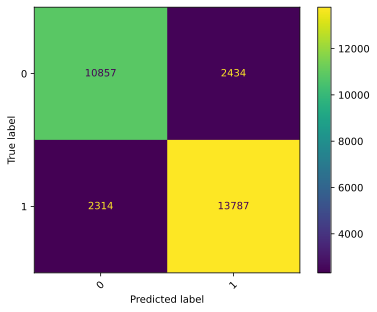

In [32]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
# labels = numtospeak
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=speaktonum)
disp.plot(xticks_rotation=45)

In [33]:
import os
from datetime import datetime


# Ensure the directory exists, create if not
os.makedirs(new_model_path, exist_ok=True)
# Define the file path
file_path = os.path.join(new_model_path, 'header.txt')

# Get the current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Write the content to the file
with open(file_path, 'w') as file:
    file.write(f"Pretrain_file: {pathstr}\n")  # Write the mpath with the label "Pretrain_file:"
    file.write(f"Date: {current_date}\n")   # Write the current date
    file.write(f"Dataset Used: {dataset_train}\n")  
    file.write (f"Model Type: {model_type}\n")
    file.write(f"Column Trained on: {column}\n")
    file.write(f"Test Results: {outputs.metrics}")



print(f"File saved successfully at: {file_path}")

File saved successfully at: /media/carol/Data/Documents/Emo_rec/NewMel/Pretraining/Gender/header.txt
